In [132]:
! pip install mplfinance

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import mplfinance as mpf
import math
from statsmodels.tsa.stattools import adfuller

In [134]:
# Write a code to read the csv file in the POWER_Point_Daily_20100101_20241231_008d62N_076d85E_LST.csv by skpping the poertions in between -BEGIN HEADER- and -END HEADER-

def read_csv_skip_header(filepath):
    """Reads a CSV file, skipping lines between '-BEGIN HEADER-' and '-END HEADER-'.

    Args:
      filepath: The path to the CSV file.

    Returns:
      A pandas DataFrame containing the data from the file, excluding the header section.
      Returns None if the file is not found or if there's an error during processing.
    """
    try:
        with open(filepath, 'r') as file:
            lines = file.readlines()
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found.")
        return None

    start_index = -1
    end_index = -1
    for i, line in enumerate(lines):
        if '-BEGIN HEADER-' in line:
            start_index = i
        elif '-END HEADER-' in line:
            end_index = i
            break  # Exit the loop once the end of the header is found

    if start_index == -1 or end_index == -1:
      print("Warning: Could not find header markers in file. Reading the file without skipping the headers.")
      try:
        df = pd.read_csv(filepath) #read the whole file without skipping the header
      except pd.errors.ParserError:
        print("Error: Cannot parse the csv file. Check that the file is properly formated.")
        return None
      return df

    # Extract lines before the header and after the header
    data_lines = lines[:start_index] + lines[end_index + 1:]

    try:
      # Create a temporary file to hold the modified data
      with open('temp.csv', 'w') as temp_file:
          temp_file.writelines(data_lines)

      # Read the temporary file into a pandas DataFrame
      df = pd.read_csv('temp.csv')

      # Clean up the temporary file
      !rm temp.csv

      return df
    except pd.errors.ParserError:
        print("Error: Cannot parse the csv file. Check that the file is properly formated.")
        return None


# Example usage:
filepath = 'data.csv'
df = read_csv_skip_header(filepath)

if df is not None:
    print(df.head())


   YEAR  MO  DY  ALLSKY_SFC_SW_DWN    T2M  WS10M
0  2010   1   1             228.73  26.30   4.26
1  2010   1   2             226.77  26.29   4.86
2  2010   1   3             225.04  26.13   4.70
3  2010   1   4             202.07  26.32   2.54
4  2010   1   5             224.18  25.85   2.43


'rm' is not recognized as an internal or external command,
operable program or batch file.


# Code to look at the distribution of the variables

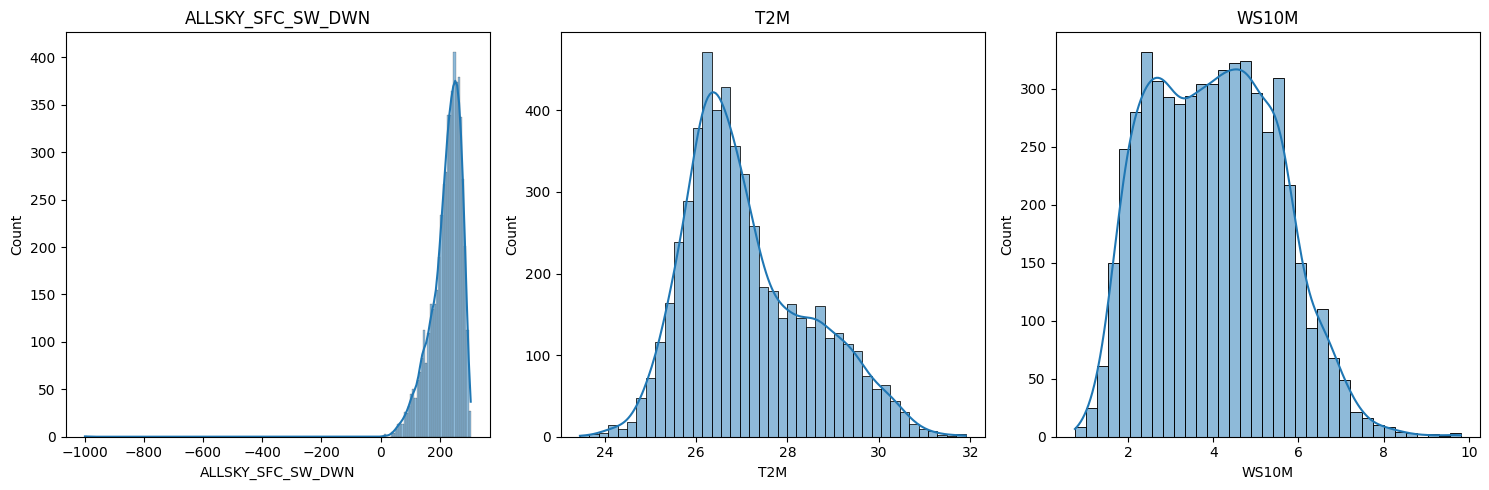

In [135]:
# Make a distribution plot of ALLSKY_SFC_SW_DWN, T2M, WS10M

import matplotlib.pyplot as plt
import seaborn as sns

if df is not None:
    # Create the distribution plots
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.histplot(df['ALLSKY_SFC_SW_DWN'], kde=True)
    plt.title('ALLSKY_SFC_SW_DWN')

    plt.subplot(1, 3, 2)
    sns.histplot(df['T2M'], kde=True)
    plt.title('T2M')

    plt.subplot(1, 3, 3)
    sns.histplot(df['WS10M'], kde=True)
    plt.title('WS10M')

    plt.tight_layout()
    plt.show()

# Removing the outliers form the ALLSKY_SFC_SW_DWN variable

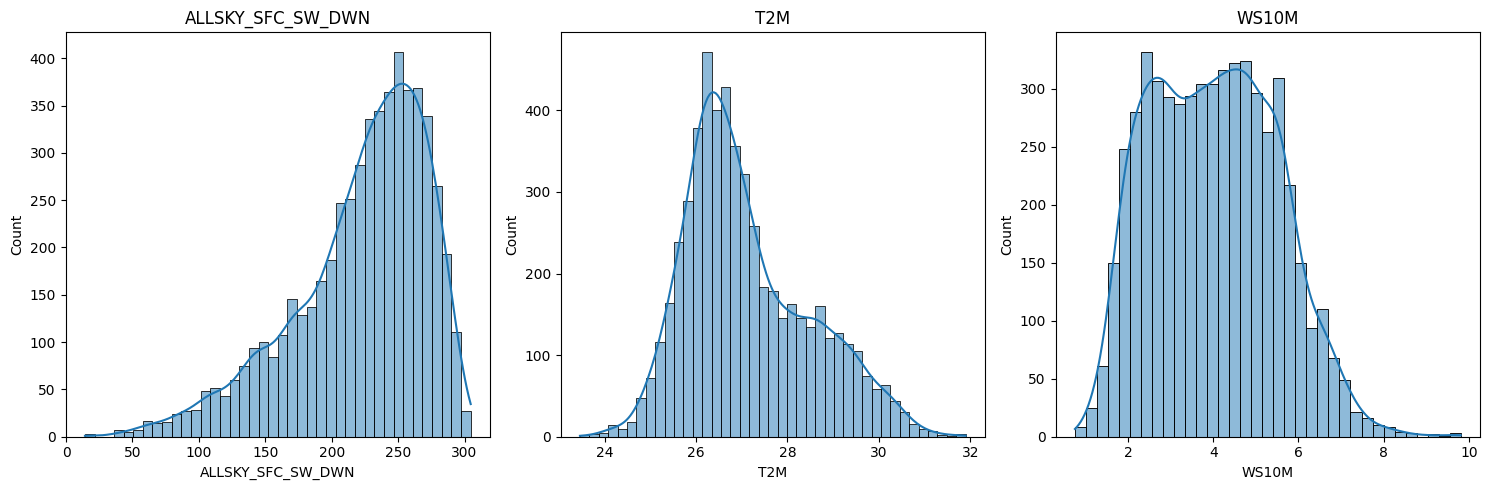

In [136]:
if df is not None:
    # Replacing -999 values with the average of previous and next valid values
    col_to_fix = 'ALLSKY_SFC_SW_DWN'  # Specify the column to fix

    valid_indices = df[df[col_to_fix] != -999].index
    for i in df.index:
      if df.loc[i, col_to_fix] == -999:
        prev_valid_index = valid_indices[valid_indices < i].max()
        next_valid_index = valid_indices[valid_indices > i].min()

        if pd.isna(prev_valid_index) or pd.isna(next_valid_index):
          continue #skip the first and the last values

        prev_val = df.loc[prev_valid_index, col_to_fix]
        next_val = df.loc[next_valid_index, col_to_fix]

        df.loc[i, col_to_fix] = (prev_val + next_val) / 2


    # print(df.head())

    # Create the distribution plots
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.histplot(df['ALLSKY_SFC_SW_DWN'], kde=True)
    plt.title('ALLSKY_SFC_SW_DWN')

    plt.subplot(1, 3, 2)
    sns.histplot(df['T2M'], kde=True)
    plt.title('T2M')

    plt.subplot(1, 3, 3)
    sns.histplot(df['WS10M'], kde=True)
    plt.title('WS10M')

    plt.tight_layout()
    plt.show()


# Estimating the wind power

In [137]:
# Create an another column in the dataset df based on the "Wind energy formula" $P = \frac{1}{2}ρAv^3$, where V is available in the WS10M column. where ρ = air density, A = swept area of blades given by Area pi*r^2,  where r is the radius of the blades. v = velocity of the wind.

# Constants
rho = 1.225  # Air density (kg/m^3)
r = 1      # Radius of the blades (meters) -  you should replace this with the actual radius
A = math.pi * (r**2) # Swept area


# Calculate the wind power
df['WindPower'] = 0.5 * rho * A * (df['WS10M'] ** 3)


<Axes: xlabel='MO', ylabel='WindPower'>

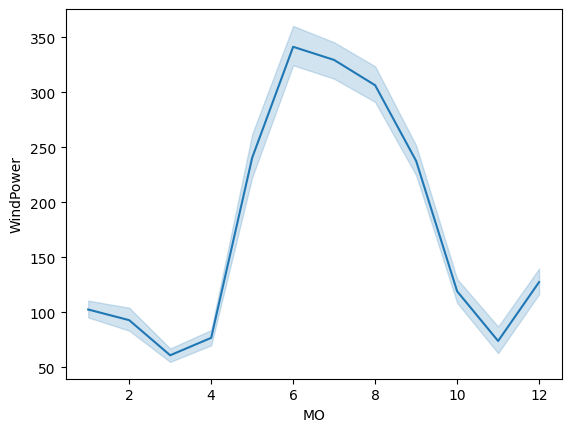

In [138]:
import seaborn as sns
sns.lineplot(y='WindPower', x='MO', data=df)

# Performing stationarity test

In [139]:
# Write a code to perform the stationarity of the time series WindPower in the dataset

if df is not None:
    # Perform the Augmented Dickey-Fuller test
    result = adfuller(df['WindPower'])

    # Print the test results
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    # Interpret the results
    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")


ADF Statistic: -6.864887
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
The time series is stationary.


# Estimating the solar power potential

To estimate the **solar panel power output** based on given **temperature** and **solar radiation**, you can use the following approach:

---

### **1. Basic Power Output Formula**

The power output \( P_{out} \) of a solar panel can be estimated using:

\[
P_{out} = P_{rated} \times \frac{G}{G_{STC}} \times [1 + \gamma (T_c - T_{ref})]
\]

Where:  
- **\( P_{rated} \)** = Rated power of the panel at **Standard Test Conditions (STC)** (usually in Watts).  
- **\( G \)** = Incident solar radiation (irradiance) on the panel in **W/m²**.  
- **\( G_{STC} \)** = Standard irradiance (typically **1000 W/m²**).  
- **\( \gamma \)** = Temperature coefficient of power (e.g., **-0.004 to -0.005/°C** for most panels).  
- **\( T_c \)** = Cell temperature in °C.  
- **\( T_{ref} \)** = Reference temperature (usually **25°C** under STC).

---

### **2. Estimating Cell Temperature \( (T_c) \)**

Since you have **ambient temperature** \( (T_{amb}) \), estimate the cell temperature using:

\[
T_c = T_{amb} + \frac{NOCT - 20}{800} \times G
\]

Where:  
- **\( NOCT \)** = Nominal Operating Cell Temperature (typically **45–48°C** under 800 W/m², 20°C ambient, 1 m/s wind).  
- **\( G \)** = Solar radiation in W/m².  

---

### **3. Complete Calculation Example**

Given:  
- \( P_{rated} = 300 \, W \)  
- \( G = 850 \, W/m² \)  
- \( T_{amb} = 30°C \)  
- \( NOCT = 45°C \)  
- \( \gamma = -0.004/°C \)  

**Step 1:** Calculate cell temperature:  
\[
T_c = 30 + \frac{45 - 20}{800} \times 850 = 30 + 26.56 = 56.56°C
\]

**Step 2:** Estimate power output:  
\[
P_{out} = 300 \times \frac{850}{1000} \times [1 + (-0.004)(56.56 - 25)]
\]
\[
P_{out} = 300 \times 0.85 \times [1 - 0.1262]
\]
\[
P_{out} \approx 300 \times 0.85 \times 0.8738 \approx 222.76 \, W
\]

---

### **4. Additional Considerations**  
- **Angle of Incidence:** Adjust \( G \) if the panel isn't optimally tilted.  
- **Dust & Degradation:** Apply performance degradation factors if needed.  
- **Inverter Efficiency:** For AC output, consider inverter efficiency (~95–98%).

Would you like a Python script to automate this calculation for your dataset?

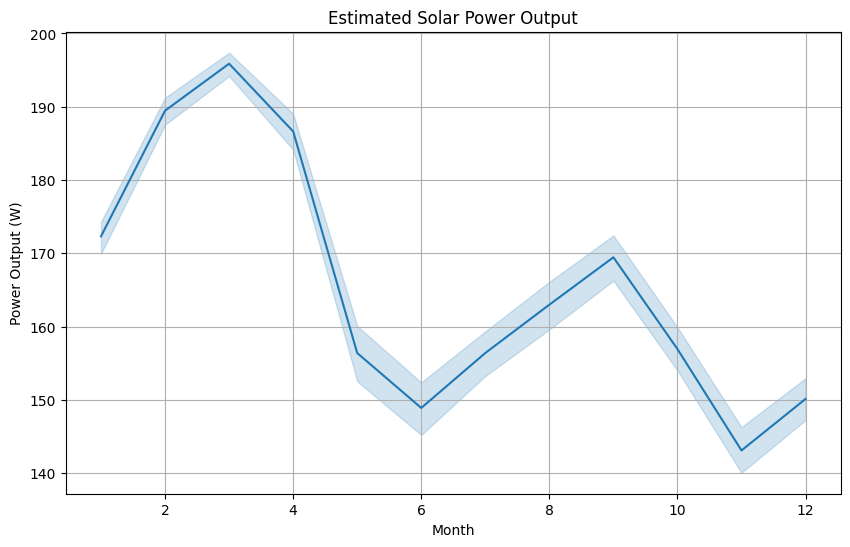

             P_out
count  5479.000000
mean    165.585614
std      35.762925
min      11.265027
25%     147.424247
50%     174.112051
75%     192.210612
max     224.281644


In [140]:
# Write a code to estimate the solar power based on P_{out} = P_{rated} \times \frac{G}{G_{STC}} \times [1 + \gamma (T_c - T_{ref})] where T_c = T_{amb} + \frac{NOCT - 20}{800} \times G

# Constants
P_rated = 400  # Rated power of the panel at STC (Watts)
G_STC = 1000   # Standard irradiance (W/m²)
gamma = -0.004  # Temperature coefficient of power (/°C)
T_ref = 25      # Reference temperature (°C)
NOCT = 45       # Nominal Operating Cell Temperature (°C)

# Calculate cell temperature and power output
df['Tc'] = df['T2M'] + ((NOCT - 20) / 800) * df['ALLSKY_SFC_SW_DWN']*2
df['P_out'] = P_rated * (2*df['ALLSKY_SFC_SW_DWN'] / G_STC) * (1 + gamma * (df['Tc'] - T_ref))

# Plotting the solar power
plt.figure(figsize=(10, 6))
sns.lineplot(x='MO', y='P_out', data=df)
plt.title('Estimated Solar Power Output')
plt.xlabel('Month')
plt.ylabel('Power Output (W)')
plt.grid(True)
plt.show()

# Print some statistics
print(df[['P_out']].describe())


# Performing stationarity test

In [141]:
# Write a code to perform the stationarity of the time series P_out in the dataset

if df is not None:
    # Perform the Augmented Dickey-Fuller test
    result = adfuller(df['P_out'])

    # Print the test results
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    # Interpret the results
    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")


ADF Statistic: -9.109350
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
The time series is stationary.


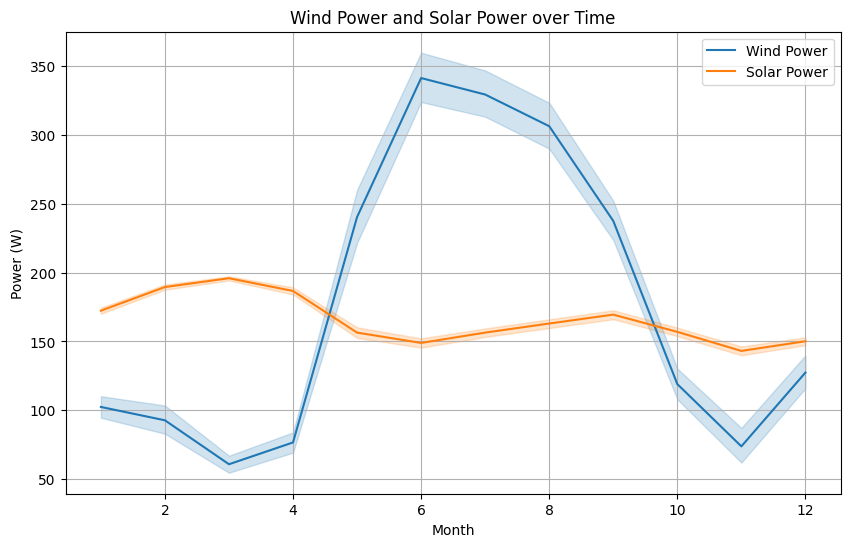

In [142]:
# make a line plot of the solar power and wind power in a same graph

plt.figure(figsize=(10, 6))
sns.lineplot(x='MO', y='WindPower', data=df, label='Wind Power')
sns.lineplot(x='MO', y='P_out', data=df, label='Solar Power')
plt.title('Wind Power and Solar Power over Time')
plt.xlabel('Month')
plt.ylabel('Power (W)')
plt.legend()
plt.grid(True)
plt.show()


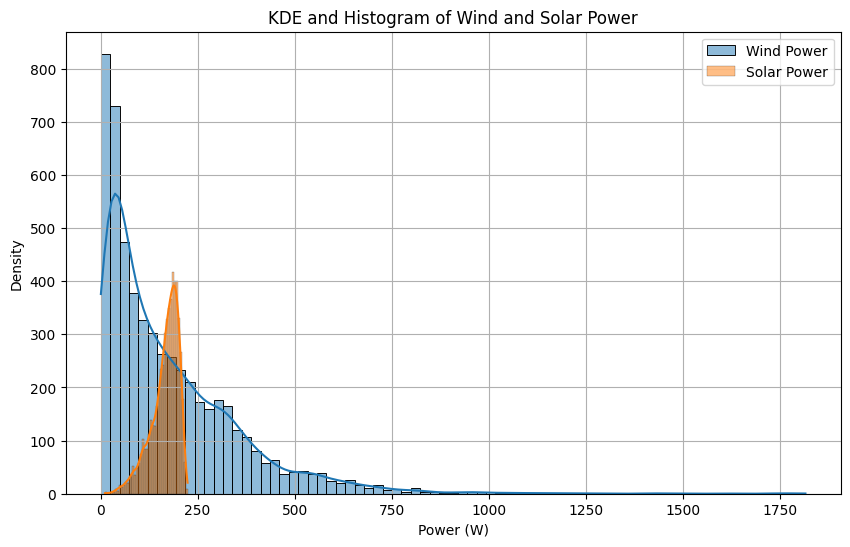

In [143]:
# make a kde plot with histogram of the solar ans wind power

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
# sns.kdeplot(df['WindPower'], label='Wind Power', shade=True)
sns.histplot(df['WindPower'], kde=True, label='Wind Power', alpha=0.5)

# sns.kdeplot(df['P_out'], label='Solar Power', shade=True)
sns.histplot(df['P_out'], kde=True, label='Solar Power', alpha=0.5)

plt.title('KDE and Histogram of Wind and Solar Power')
plt.xlabel('Power (W)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


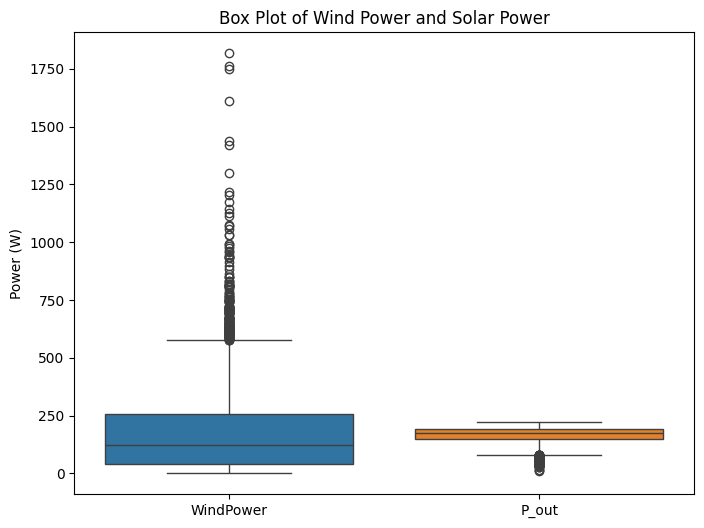

In [144]:
# make a box plot

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(data=df[['WindPower', 'P_out']])
plt.title('Box Plot of Wind Power and Solar Power')
plt.ylabel('Power (W)')
plt.show()


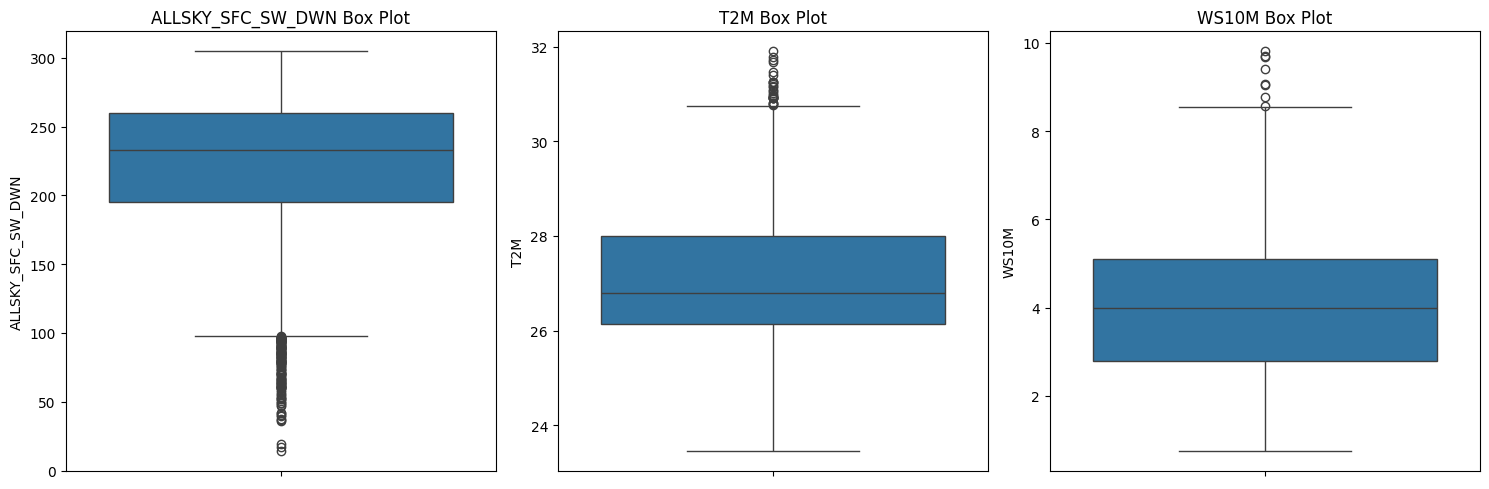

In [145]:
# make a box plot of ALLSKY_SFC_SW_DWN, T2M, and Wind speed as sub figures

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=df['ALLSKY_SFC_SW_DWN'])
plt.title('ALLSKY_SFC_SW_DWN Box Plot')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['T2M'])
plt.title('T2M Box Plot')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['WS10M'])
plt.title('WS10M Box Plot')

plt.tight_layout()
plt.show()


In [146]:
# count how many outliers

# Calculate the number of outliers for WindPower
Q1_wind = df['WindPower'].quantile(0.25)
Q3_wind = df['WindPower'].quantile(0.75)
IQR_wind = Q3_wind - Q1_wind
lower_bound_wind = Q1_wind - 1.5 * IQR_wind
upper_bound_wind = Q3_wind + 1.5 * IQR_wind

outliers_wind = df[(df['WindPower'] < lower_bound_wind) | (df['WindPower'] > upper_bound_wind)]
num_outliers_wind = len(outliers_wind)

print(f"Number of outliers in WindPower: {num_outliers_wind}")

# Calculate the number of outliers for P_out
Q1_solar = df['P_out'].quantile(0.25)
Q3_solar = df['P_out'].quantile(0.75)
IQR_solar = Q3_solar - Q1_solar
lower_bound_solar = Q1_solar - 1.5 * IQR_solar
upper_bound_solar = Q3_solar + 1.5 * IQR_solar

outliers_solar = df[(df['P_out'] < lower_bound_solar) | (df['P_out'] > upper_bound_solar)]
num_outliers_solar = len(outliers_solar)

print(f"Number of outliers in P_out: {num_outliers_solar}")


Number of outliers in WindPower: 188
Number of outliers in P_out: 157


In [147]:
df.shape

(5479, 9)

In [148]:
#  remove the outliers of WindPower and P_out from the data set

# Calculate the number of outliers for WindPower
Q1_wind = df['WindPower'].quantile(0.25)
Q3_wind = df['WindPower'].quantile(0.75)
IQR_wind = Q3_wind - Q1_wind
lower_bound_wind = Q1_wind - 1.5 * IQR_wind
upper_bound_wind = Q3_wind + 1.5 * IQR_wind

# Remove outliers for WindPower
df_no_outliers = df[(df['WindPower'] >= lower_bound_wind) & (df['WindPower'] <= upper_bound_wind)]

# Calculate the number of outliers for P_out
Q1_solar = df_no_outliers['P_out'].quantile(0.25)
Q3_solar = df_no_outliers['P_out'].quantile(0.75)
IQR_solar = Q3_solar - Q1_solar
lower_bound_solar = Q1_solar - 1.5 * IQR_solar
upper_bound_solar = Q3_solar + 1.5 * IQR_solar

# Remove outliers for P_out
df_no_outliers = df_no_outliers[(df_no_outliers['P_out'] >= lower_bound_solar) & (df_no_outliers['P_out'] <= upper_bound_solar)]

print(f"Original shape: {df.shape}")
print(f"Shape after outlier removal: {df_no_outliers.shape}")


Original shape: (5479, 9)
Shape after outlier removal: (5115, 9)


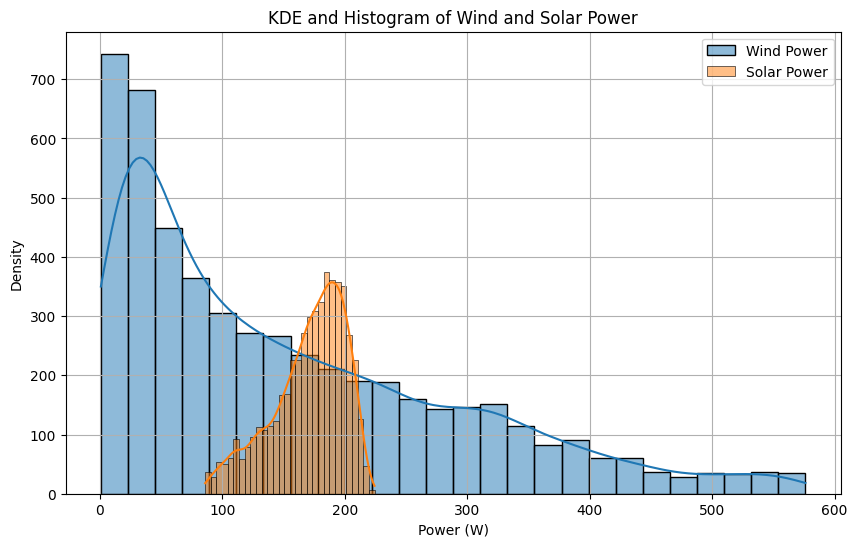

In [149]:
# make a kde plot with histogram of the solar ans wind power

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
# sns.kdeplot(df['WindPower'], label='Wind Power', shade=True)
sns.histplot(df_no_outliers['WindPower'], kde=True, label='Wind Power', alpha=0.5)

# sns.kdeplot(df['P_out'], label='Solar Power', shade=True)
sns.histplot(df_no_outliers['P_out'], kde=True, label='Solar Power', alpha=0.5)

plt.title('KDE and Histogram of Wind and Solar Power')
plt.xlabel('Power (W)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [150]:
# calculate the variance of wind and solar power

# Calculate the variance of 'WindPower' and 'P_out'
wind_variance = df_no_outliers['WindPower'].var()
solar_variance = df_no_outliers['P_out'].var()

print(f"Variance of Wind Power: {wind_variance}")
print(f"Variance of Solar Power: {solar_variance}")


Variance of Wind Power: 18282.206739966685
Variance of Solar Power: 880.3009720431523


# Portfolio

To optimize the two energy portfolios (solar and wind) to **minimize volatility** in energy production, you can apply a **mean-variance optimization** approach similar to financial portfolio optimization. Here’s how you can proceed:

---

### **1. Define Variables**

- **\( E_s(t) \)** = Energy from solar at time \( t \)  
- **\( E_w(t) \)** = Energy from wind at time \( t \)  
- **\( w_s \)** = Weight of solar energy in the portfolio  
- **\( w_w = 1 - w_s \)** = Weight of wind energy  

The **total portfolio energy** at time \( t \) is:  
$
E_{portfolio}(t) = w_s \cdot E_s(t) + w_w \cdot E_w(t)$

---

### **2. Calculate Volatility (Variance)**

The **portfolio variance** is:  
\[
\sigma_p^2 = w_s^2 \cdot \sigma_s^2 + w_w^2 \cdot \sigma_w^2 + 2 \cdot w_s \cdot w_w \cdot \text{Cov}(E_s, E_w)
\]

Where:  
- **\( \sigma_s^2 \)** = Variance of solar energy  
- **\( \sigma_w^2 \)** = Variance of wind energy  
- **Cov(\( E_s, E_w \))** = Covariance between solar and wind energy  

---

### **3. Optimization Problem**

You want to **minimize \( \sigma_p^2 \)** subject to:  
1. \( w_s + w_w = 1 \) (full allocation)  
2. \( 0 \leq w_s, w_w \leq 1 \) (non-negative weights)

The optimization problem becomes:  
\[
\min_{w_s} \, \sigma_p^2
\]

You can solve this using:  
- **Quadratic Programming (QP)** (common for portfolio optimization)  
- **SciPy’s `optimize.minimize`** (Python)  

---

### **4. Python Example (Using SciPy)**

```python
import numpy as np
from scipy.optimize import minimize

# Example data (replace with actual values)
solar_energy = np.array([...])  # Solar energy time series
wind_energy = np.array([...])   # Wind energy time series

# Variances and covariance
var_solar = np.var(solar_energy)
var_wind = np.var(wind_energy)
cov_sw = np.cov(solar_energy, wind_energy)[0, 1]

# Objective function: Portfolio variance
def portfolio_variance(weights):
    w_s, w_w = weights
    return w_s**2 * var_solar + w_w**2 * var_wind + 2 * w_s * w_w * cov_sw

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: weights between 0 and 1
bounds = ((0, 1), (0, 1))

# Initial guess
initial_guess = [0.5, 0.5]

# Optimization
result = minimize(portfolio_variance, initial_guess, bounds=bounds, constraints=constraints)
optimal_weights = result.x

print(f"Optimal Solar Weight: {optimal_weights[0]:.2f}")
print(f"Optimal Wind Weight: {optimal_weights[1]:.2f}")
```

---

### **5. Sensitivity and Seasonal Analysis**

After optimization:  
- **Check the seasonal variability** of the optimized portfolio.  
- **Stress-test** the portfolio under extreme weather conditions to assess robustness.

Would you like me to expand on any specific part, such as seasonal adjustments, advanced optimization techniques, or visualization?

In [151]:
# prompt: consider the dataset df_no_outliers and the variables solar_energy: P_out and wind_energy: WindPower. construct the total portfolio energy. and minimize the Portfolio variance

import numpy as np
from scipy.optimize import minimize

# Assuming df_no_outliers DataFrame and 'WindPower', 'P_out' columns exist

# Variances and covariance
var_solar = df_no_outliers['P_out'].var()
var_wind = df_no_outliers['WindPower'].var()
cov_sw = df_no_outliers[['P_out', 'WindPower']].cov().iloc[0, 1]

# Objective function: Portfolio variance
def portfolio_variance(weights):
    w_s = weights[0]
    w_w = 1 - w_s  # w_w is dependent on w_s
    return w_s**2 * var_solar + w_w**2 * var_wind + 2 * w_s * w_w * cov_sw

# Bounds: weights between 0 and 1 (adjust as needed)
bounds = [(0, 1)]

# Initial guess
initial_guess = [0.5]

# Optimization
result = minimize(portfolio_variance, initial_guess, bounds=bounds)
optimal_solar_weight = result.x[0]
optimal_wind_weight = 1 - optimal_solar_weight

print(f"Optimal Solar Weight: {optimal_solar_weight:.2f}")
print(f"Optimal Wind Weight: {optimal_wind_weight:.2f}")

# Calculate the total portfolio energy
df_no_outliers['PortfolioEnergy'] = (optimal_solar_weight * df_no_outliers['P_out'] +
                                     optimal_wind_weight * df_no_outliers['WindPower'])

# Calculate and print the portfolio variance
portfolio_variance = df_no_outliers['PortfolioEnergy'].var()
print(f"Portfolio Variance: {portfolio_variance:.2f}")


Optimal Solar Weight: 0.92
Optimal Wind Weight: 0.08
Portfolio Variance: 764.54


In [152]:
df_no_outliers

,YEAR,MO,DY,ALLSKY_SFC_SW_DWN,T2M,WS10M,WindPower,Tc,P_out,PortfolioEnergy
0,2010,1,1,228.73,26.30,4.26,148.759518,40.595625,171.569001,169.854177
1,2010,1,2,226.77,26.29,4.86,220.884262,40.463125,170.194967,174.005804
2,2010,1,3,225.04,26.13,4.70,199.778864,40.195000,169.089655,171.396879
3,2010,1,4,202.07,26.32,2.54,31.532406,38.949375,152.635999,143.531394
4,2010,1,5,224.18,25.85,2.43,27.610533,39.861250,168.682896,158.077032
...,...,...,...,...,...,...,...,...,...,...
5474,2024,12,27,190.48,27.47,2.19,20.211024,39.375000,143.621920,134.343851
5475,2024,12,28,187.63,26.53,4.40,163.913225,38.256875,142.144360,143.780950
5476,2024,12,29,232.54,26.57,3.17,61.296228,41.103750,174.048749,165.571980
5477,2024,12,30,128.65,26.47,2.78,41.341893,34.510625,99.004666,94.669561


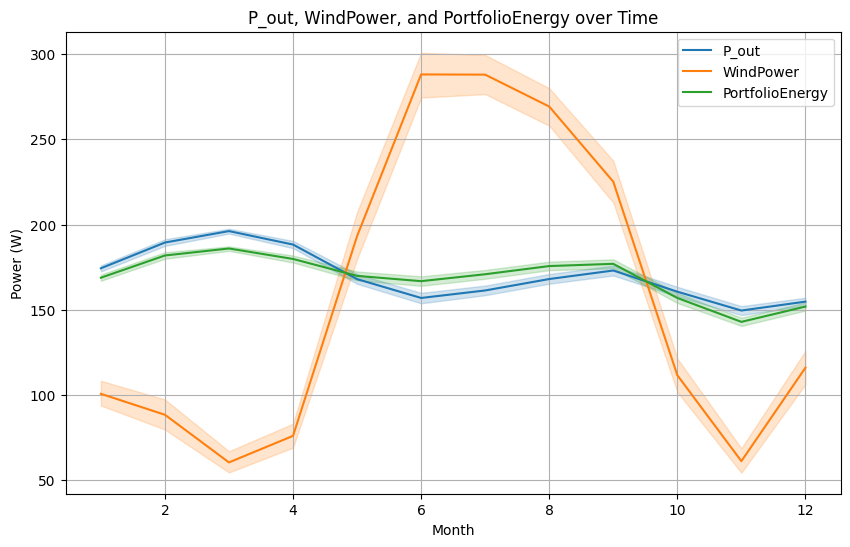

In [153]:
# prompt: make line plot of P_out, WindPower, and PortfolioEnergy

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(x='MO', y='P_out', data=df_no_outliers, label='P_out')
sns.lineplot(x='MO', y='WindPower', data=df_no_outliers, label='WindPower')
sns.lineplot(x='MO', y='PortfolioEnergy', data=df_no_outliers, label='PortfolioEnergy')
plt.title('P_out, WindPower, and PortfolioEnergy over Time')
plt.xlabel('Month')
plt.ylabel('Power (W)')
plt.legend()
plt.grid(True)
plt.show()


In [154]:
# create a new dataset containing date and PortfolioEnergy from the df_no_outliers dataset. In order to construct the date column consider the YEAR, MO, and DY columns. Resolve the error. Rename the columns in df_no_outliers YEAR to year, MO to month, DY to day

import pandas as pd

# Assuming df_no_outliers is already defined and has columns 'YEAR', 'MO', 'DY'
# Rename columns
df_no_outliers = df_no_outliers.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day'})

# Combine year, month, and day into a date column
df_no_outliers['date'] = pd.to_datetime(df_no_outliers[['year', 'month', 'day']])

# Create the new dataset
new_dataset = df_no_outliers[['date', 'PortfolioEnergy']].copy()
new_dataset.set_index('date', inplace=True)

new_dataset.head()

,PortfolioEnergy
date,
2010-01-01,169.854177
2010-01-02,174.005804
2010-01-03,171.396879
2010-01-04,143.531394
2010-01-05,158.077032


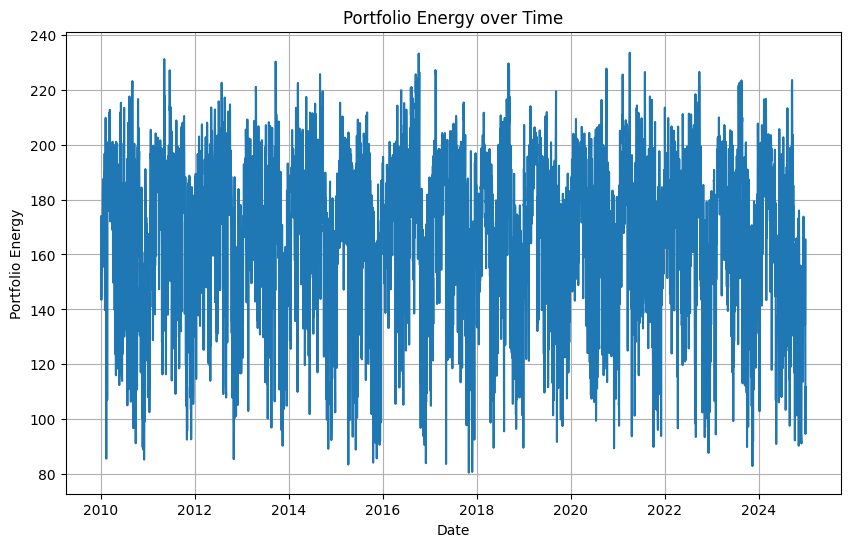

In [155]:
# plot the new_dataset

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'new_dataset' is a pandas DataFrame with 'date' and 'PortfolioEnergy' columns.
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='PortfolioEnergy', data=new_dataset)
plt.title('Portfolio Energy over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Energy')
plt.grid(True)
plt.show()


In [156]:
# Split the new_dataset into train and test such that dat till 2023 is taken as train and remaining data is taken as test.

import pandas as pd
# Assuming 'new_dataset' is already defined and has a 'date' index.

# Convert the index to datetime objects if it's not already
new_dataset.index = pd.to_datetime(new_dataset.index)

# Split the data into train and test sets
train_data = new_dataset[new_dataset.index.year < 2024]
test_data = new_dataset[new_dataset.index.year >= 2024]

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (4786, 1)
Test data shape: (329, 1)


# Swetha Please Perfrom SARIMA and LSTM on  

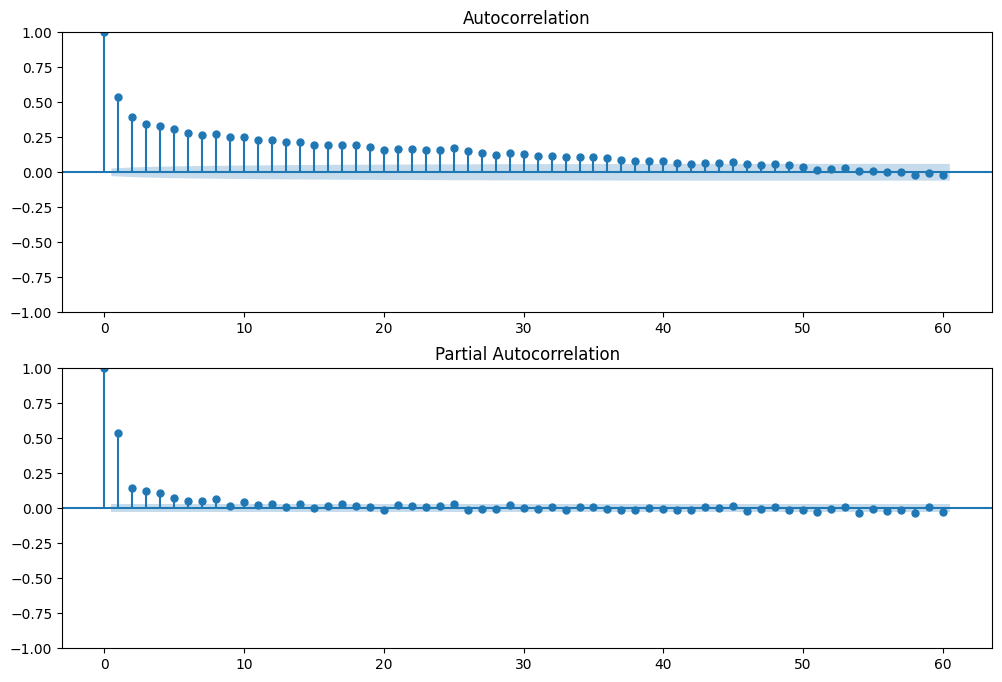

In [157]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(new_dataset['PortfolioEnergy'],lags=60,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(new_dataset['PortfolioEnergy'],lags=60,ax=ax2)

In [158]:
from statsmodels.tsa.arima.model import ARIMA
modela=ARIMA(new_dataset['PortfolioEnergy'],order=(2,1,0))
modela_fit=modela.fit()
modela_fit.summary()

c:\Users\swe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        PortfolioEnergy   No. Observations:                 5115
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -23534.467
Date:                Tue, 04 Feb 2025   AIC                          47074.935
Time:                        10:31:25   BIC                          47094.554
Sample:                             0   HQIC                         47081.803
                               - 5115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4277      0.012    -35.685      0.000      -0.451      -0.404
ar.L2         -0.2514      0.012    -20.461      0.000      -0.275      -0.227
sigma2       581.9560      9.675     60.149      0.000     562.993     600.919
===================================================================================
Ljung-Box (L1) (Q):                  13.26   Jarque-Bera (JB):               229.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.28
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [159]:
import statsmodels.api as sm
# models=sm.tsa.statespace.SARIMAX(df['Efficiency'],order=(0,0,1),seasonal_order=(1,0,0,12))
models=sm.tsa.statespace.SARIMAX(new_dataset['PortfolioEnergy'],order=(2,1,1),seasonal_order=(1,1,0,12))

models_fit=models.fit()
models_fit.summary()

c:\Users\swe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\swe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                     PortfolioEnergy   No. Observations:                 5115
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 12)   Log Likelihood              -24139.876
Date:                             Tue, 04 Feb 2025   AIC                          48289.753
Time:                                     10:31:37   BIC                          48322.440
Sample:                                          0   HQIC                         48301.197
                                            - 5115                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3971      0.013     30.866      0.000       0.372       0.422
ar.L2          0.0855      0.014      6.314      0.000       0.059       0.112
ma.L1         -1.0000      0.061    -16.372      0.000      -1.120      -0.880
ar.S.L12      -0.4793      0.011    -42.155      0.000      -0.502      -0.457
sigma2       752.1131     47.555     15.816      0.000     658.908     845.318
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):               144.07
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.30
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

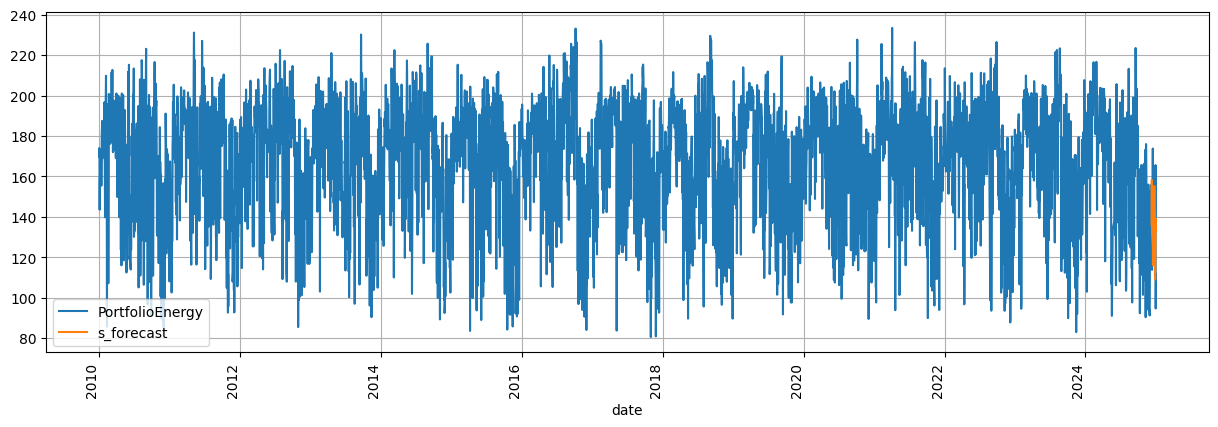

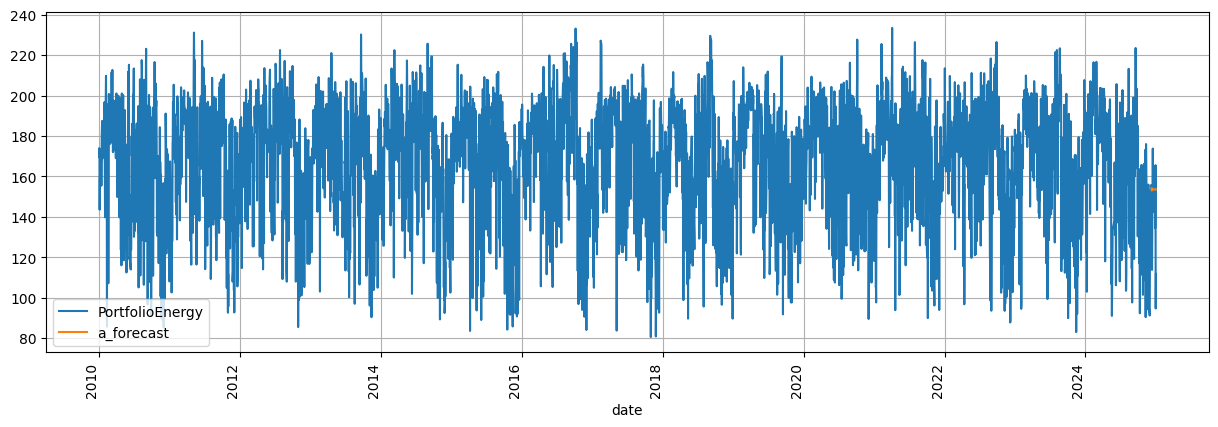

In [160]:
new_dataset['s_forecast']=models_fit.predict(start=5095,end=5114,dynamic=True)
new_dataset['a_forecast']=modela_fit.predict(start=5095,end=5114,dynamic=True)


new_dataset[['PortfolioEnergy','s_forecast']].plot(figsize=(15,5))
plt.xticks(rotation = 90)
plt.grid()
plt.show()

new_dataset[['PortfolioEnergy','a_forecast']].plot(figsize=(15,5))
plt.xticks(rotation = 90)
plt.grid()
plt.show()

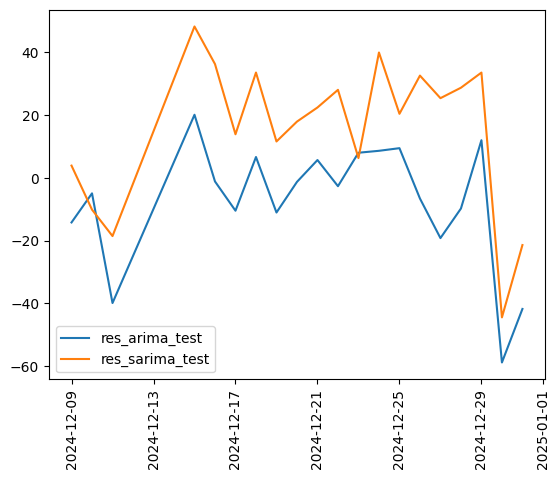

ARIMA rmse test 20.7896025895933
SARIMA rmse test 27.695010041942226


In [161]:
res_a = new_dataset["PortfolioEnergy"][5095:]-new_dataset["a_forecast"][5095:]
plt.plot(res_a, label="res_arima_test")
res_s = new_dataset["PortfolioEnergy"][5095:]-new_dataset["s_forecast"][5095:]
plt.plot(res_s,label="res_sarima_test")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

rmse_a = np.sqrt(np.mean(res_a**2))
rmse_s = np.sqrt(np.mean(res_s**2))

print("ARIMA rmse test", rmse_a)
print("SARIMA rmse test", rmse_s)


c:\Users\swe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\swe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\swe\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


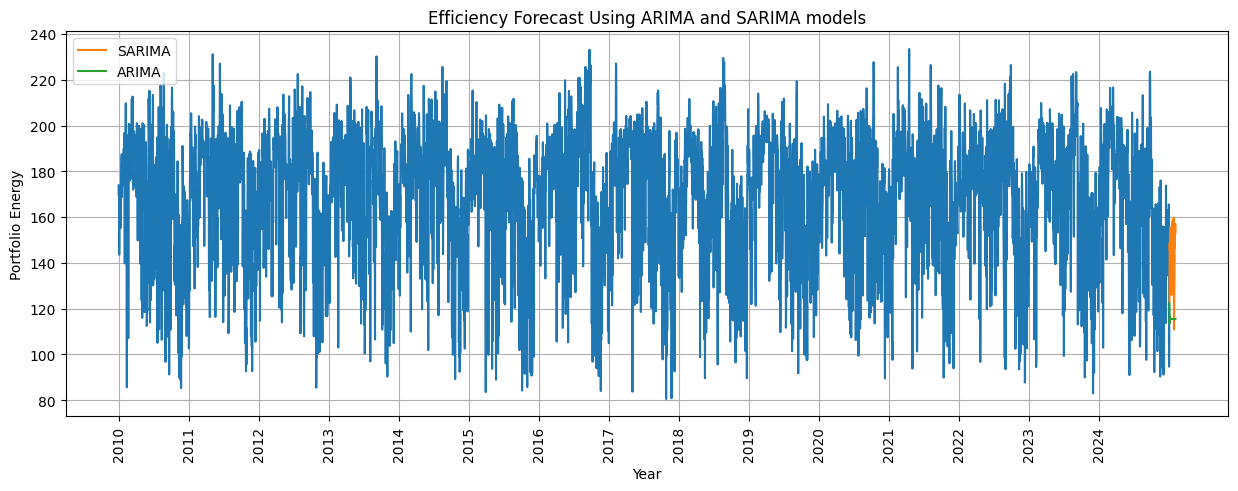

In [165]:
s_forecast_future=models_fit.forecast(30)
a_forecast_future=modela_fit.forecast(30)
new_dataset["s_forecast_future"] = None
new_dataset["a_forecast_future"] = None
new_dataset=new_dataset.reset_index()
plt.figure(figsize=(15,5))
plt.plot(new_dataset['PortfolioEnergy'])
plt.plot(new_dataset["s_forecast_future"]._append(s_forecast_future[:]),label="SARIMA")
plt.plot(new_dataset["a_forecast_future"]._append(a_forecast_future[:]),label="ARIMA")
plt.legend()
years = np.arange(2010,2025)
index = np.arange(0,5114,341)
plt.xticks(ticks = index,labels = years,rotation = 90)
plt.ylabel("Portfolio Energy")
plt.xlabel("Year")
plt.title("Efficiency Forecast Using ARIMA and SARIMA models")
plt.grid()
plt.show()

LSTM

In [163]:
# LSTM final
#https://stackoverflow.com/questions/69906416/forecast-future-values-with-lstm-in-python/69912334#69912334
lookback = 60
n_forecast = 30
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
def create_dataset(y, n_lookback, n_forecast=30):
 X, Y = [], []
 for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])
 return np.array(X), np.array(Y)


# fix random seed for reproducibility
tf.random.set_seed(0)

# load the dataset
# dataframe = pd.DataFrame(new_dataset.index.values)
# dataframe["PE"] = new_dataset['PortfolioEnergy']
dataframe = pd.DataFrame(new_dataset['PortfolioEnergy'])
dataset = dataframe.values
# print(dataframe.head())

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


train_size = int(len(dataset) * 1)
train = dataset[0:train_size]

# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train, lookback)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, lookback)))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=1, verbose=2)
plt.plot(history.history["loss"])
plt.xlabel("Training Loss for LSTM (Dense = 30)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


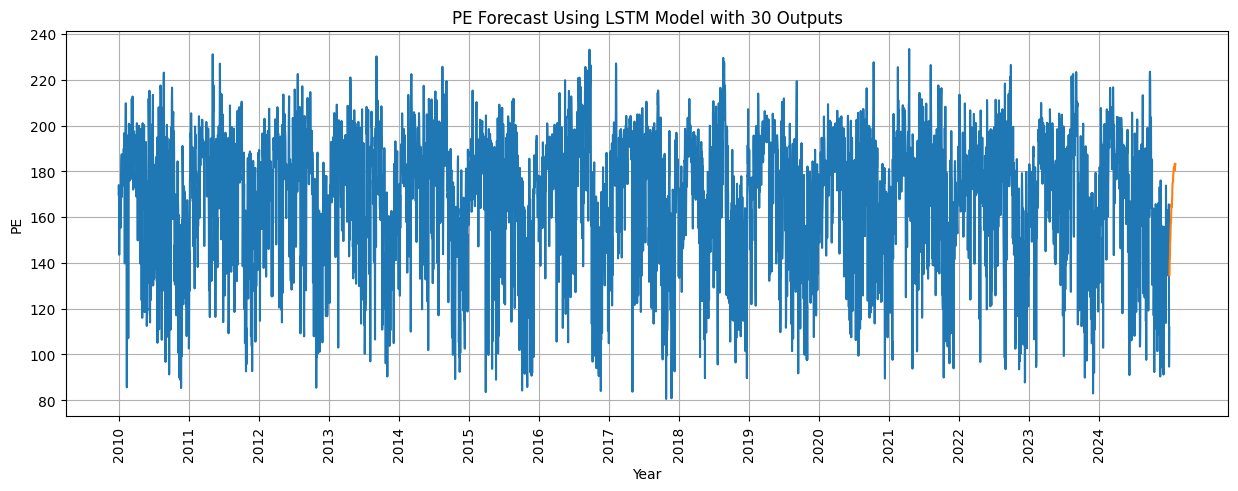

In [164]:
X_ = dataset[- lookback:]  # last available input sequence
X_ = X_.reshape(1,1, lookback)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)
a = np.empty_like(dataset)
a[:,:] = np.nan
Y_=np.append(a,Y_)

# plot baseline and predictions

plt.figure(figsize=(15,5))
years = np.arange(2010,2025)
index = np.arange(0,5114,341)
plt.plot(scaler.inverse_transform(dataset))
plt.xticks(ticks = index,labels = years,rotation = 90)
plt.ylabel("PE")
plt.xlabel("Year")
plt.title("PE Forecast Using LSTM Model with 30 Outputs")
plt.grid()
plt.plot(Y_)
plt.show()


Epoch 1/300


c:\Users\swe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5085/5085 - 7s - 1ms/step - loss: 0.0266
Epoch 2/300
5085/5085 - 6s - 1ms/step - loss: 0.0230
Epoch 3/300
5085/5085 - 6s - 1ms/step - loss: 0.0226
Epoch 4/300
5085/5085 - 6s - 1ms/step - loss: 0.0224
Epoch 5/300
5085/5085 - 6s - 1ms/step - loss: 0.0223
Epoch 6/300
5085/5085 - 6s - 1ms/step - loss: 0.0222
Epoch 7/300
5085/5085 - 5s - 1ms/step - loss: 0.0221
Epoch 8/300
5085/5085 - 5s - 1ms/step - loss: 0.0221
Epoch 9/300
5085/5085 - 5s - 1ms/step - loss: 0.0220
Epoch 10/300
5085/5085 - 6s - 1ms/step - loss: 0.0219
Epoch 11/300
5085/5085 - 6s - 1ms/step - loss: 0.0219
Epoch 12/300
5085/5085 - 6s - 1ms/step - loss: 0.0218
Epoch 13/300
5085/5085 - 6s - 1ms/step - loss: 0.0218
Epoch 14/300
5085/5085 - 5s - 1ms/step - loss: 0.0217
Epoch 15/300
5085/5085 - 6s - 1ms/step - loss: 0.0217
Epoch 16/300
5085/5085 - 6s - 1ms/step - loss: 0.0217
Epoch 17/300
5085/5085 - 6s - 1ms/step - loss: 0.0216
Epoch 18/300
5085/5085 - 6s - 1ms/step - loss: 0.0216
Epoch 19/300
5085/5085 - 6s - 1ms/step - loss: 0.

Text(0.5, 0, 'Training Loss for LSTM (Dense = 1)')

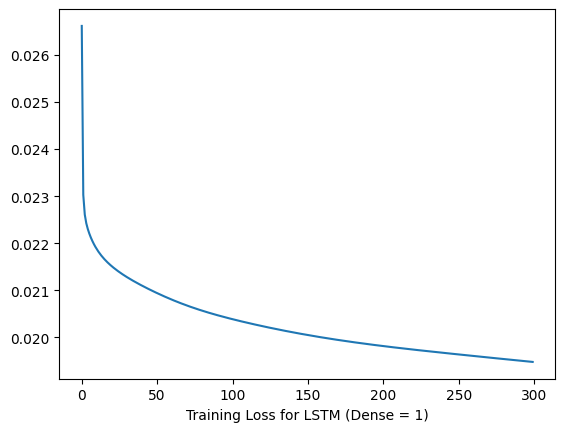

In [166]:
# LSTM - single output
#https://stackoverflow.com/questions/69906416/forecast-future-values-with-lstm-in-python/69912334#69912334
lookback = 30
n_forecast = 1
# # convert an array of values into a dataset matrix
def create_dataset(y, n_lookback, n_forecast=1):
 X, Y = [], []
 for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])
 return np.array(X), np.array(Y)


# fix random seed for reproducibility
tf.random.set_seed(0)

# # load the dataset
# dataframe = pd.DataFrame(df.index.values)
# dataframe["Eff"] = df["Efficiency"]
dataframe = pd.DataFrame(new_dataset['PortfolioEnergy'])
dataset = dataframe.values

# # normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


train_size = int(len(dataset) * 1)
train = dataset[0:train_size]

# # reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train, lookback)

# # reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

# # create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, lookback)))
model.add(Dense(n_forecast))
model.compile(loss='mean_squared_error', optimizer='adam')
history1 = model.fit(trainX, trainY, epochs=300, batch_size=1, verbose=2)
plt.plot(history1.history["loss"])
plt.xlabel("Training Loss for LSTM (Dense = 1)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

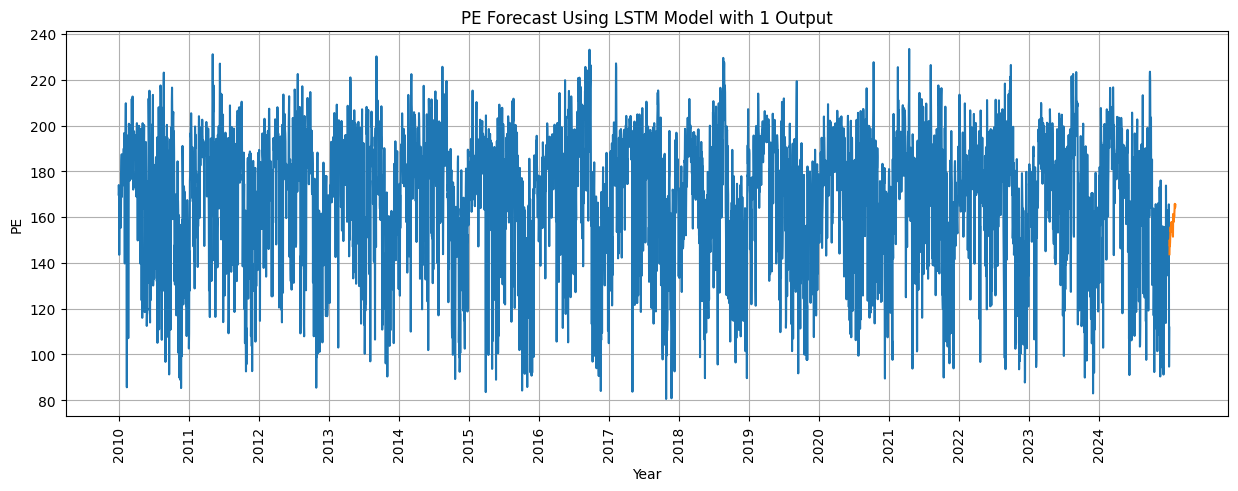

In [167]:
X_1 = dataset[- lookback:]  # last available input sequence
X_1 = X_1.reshape(1,1, lookback)

Y1 = []
for i in range(30):
  Y_1 = model.predict(X_1).reshape(-1, 1)
  Y1.append(scaler.inverse_transform(Y_1))
  Y_1 = Y_1.reshape(1,1,1)
  X_1 = X_1[:,:,1:]
#   print(X_1.ndim)
  X_1 = np.append(X_1,Y_1,axis=2)
  
Y11=[]
# Y_1 = scaler.inverse_transform(Y_1)
a = np.empty_like(dataset)
a[:,:] = np.nan
print(Y1)
Y1=np.append(a,Y1)
# print(Y1[120:])

# plot baseline and predictions
plt.figure(figsize=(15,5))
years = np.arange(2010,2025)
index = np.arange(0,5114,341)
plt.plot(scaler.inverse_transform(dataset))
plt.xticks(ticks = index,labels = years,rotation = 90)
plt.title("PE Forecast Using LSTM Model with 1 Output")
plt.grid()
plt.ylabel("PE")
plt.xlabel("Year")
plt.plot(Y1)
plt.show()